In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import zipfile

# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"




Features with zero variance after filtering: 0


In [18]:
''' Pipeline implementation random forests'''


# Define the pipeline for RandomForestClassifier
pipeline_rfc = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('rfc', RandomForestClassifier(random_state=42))
])

# Parameter grid for RandomForestClassifier
param_grid_rfc = {
    'select_k__k': [10, 20, 30, 40, 50],
    'rfc__n_estimators': [100, 200],
    'rfc__max_depth': [5, 10, None]
}

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

# Grid search for RandomForestClassifier
grid_search_rfc = GridSearchCV(pipeline_rfc, param_grid_rfc, cv=5, n_jobs=-1, verbose=1)
grid_search_rfc.fit(X_train, Y_train)

# Best parameters and score for RandomForestClassifier
print("Best parameters for RandomForestClassifier:", grid_search_rfc.best_params_)
print("Best cross-validation score for RandomForestClassifier: {:.3f}".format(grid_search_rfc.best_score_))

# Evaluate the best RandomForestClassifier model on the test set
best_rfc = grid_search_rfc.best_estimator_
Y_pred_rfc = best_rfc.predict(X_test)
print("Accuracy for RandomForestClassifier on test set:", accuracy_score(Y_test, Y_pred_rfc))
print("F1 Score for RandomForestClassifier on test set:", f1_score(Y_test, Y_pred_rfc, average='macro'))
print("Classification Report for RandomForestClassifier:\n", classification_report(Y_test, Y_pred_rfc))

# Display confusion matrix for RandomForestClassifier
cm_rfc = confusion_matrix(Y_test, Y_pred_rfc)
disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)
disp_rfc.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

Fitting 5 folds for each of 530 candidates, totalling 2650 fits
Best parameters found: {'estimator': RandomForestClassifier(random_state=42), 'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'select_k__k': 40}
Best cross-validation score: 0.957
Accuracy on test set: 0.95496417604913
F1 Score on test set: 0.9230829790584161
Classification Report:
               precision    recall  f1-score   support

     aerobic       0.96      0.98      0.97       795
   anaerobic       0.92      0.84      0.87       182

    accuracy                           0.95       977
   macro avg       0.94      0.91      0.92       977
weighted avg       0.95      0.95      0.95       977



'# Confusion Matrix Display\ntitles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]\nfor title, normalize in titles_options:\n    disp = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap=plt.cm.Blues, normalize=normalize)\n    disp.ax_.set_title(title)\n    print(title)\n    print(disp.confusion_matrix)\n\nplt.show()'

Most selected KO terms for predicting oxygen trait in hierchical manner (F score):
Index(['K01589', 'K00164', 'K01772', 'K05919', 'K01599', 'K00254', 'K02259',
       'K04070', 'K02257', 'K01163', 'K13628', 'K02823', 'K07138', 'K01677',
       'K16951', 'K00940', 'K11358', 'K17828', 'K00176', 'K01679', 'K03644',
       'K09157', 'K00674', 'K07166', 'K01902', 'K03737', 'K01903', 'K07146',
       'K03635', 'K22405', 'K00177', 'K18330', 'K03575', 'K03801', 'K06980',
       'K01633', 'K00241', 'K02276', 'K00658', 'K06891', 'K00390', 'K15635',
       'K07735', 'K10563', 'K03118', 'K01698', 'K01719', 'K03660', 'K00610',
       'K00533'],
      dtype='object', name='KO')


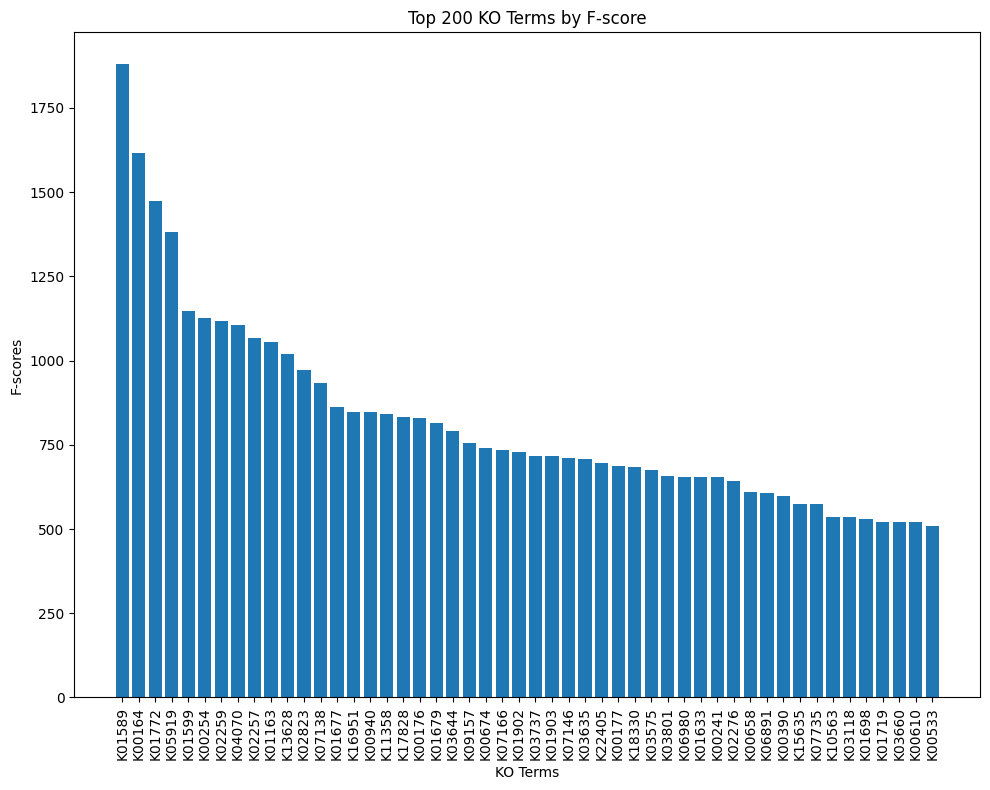

In [20]:
''' Finding best traits '''

# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=50)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

''' Plot for visualizing distribution and importance of best traits'''

# bar plot shows distribution of F-scores for the selected features
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_features)), sorted_scores)
plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
plt.xlabel('KO Terms')
plt.ylabel('F-scores')
plt.title('Top 50 KO Terms by F-score')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()
